# Sensor Degradation Detection via LSTM Autoencoder

**Project SHIELD — Degradation Detection Module**

This notebook implements an LSTM autoencoder-based approach for detecting early sensor degradation. The core idea is to train the autoencoder on healthy sensor data only, then use reconstruction error as an anomaly score to detect degraded signals.

## Methodology

1. **Training Phase**: Learn normal sensor behavior by training an LSTM autoencoder to reconstruct healthy sensor windows.
2. **Inference Phase**: For new data, compute reconstruction error. High error indicates anomalous (degraded) behavior.
3. **Threshold Calibration**: Set detection threshold at the 95th percentile of healthy reconstruction errors.

## Synthetic Degradation Types

Since real degraded sensor data is scarce, we inject synthetic faults for evaluation:
- **Noise floor elevation**: Growing additive noise
- **Bias drift**: Calibration offset that increases over time
- **Spike injection**: Random anomalous spikes
- **Bandwidth loss**: High-frequency attenuation (smoothing)
- **Saturation/clipping**: Signal clipping at thresholds
- **Gain change**: Amplitude scaling (attenuation or amplification)

---
## 1. Setup and Configuration

In [1]:
import os
import sys
import json
import glob
import warnings
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.ndimage import uniform_filter1d

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# Reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Plotting configuration
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.size': 10,
    'axes.titlesize': 12,
    'axes.labelsize': 10,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3,
    'figure.facecolor': 'white',
})

# Color scheme
COLORS = {
    'healthy': '#2E86AB',
    'degraded': '#D64045',
    'train': '#2E86AB',
    'val_healthy': '#28A745',
    'threshold': '#7B2D8E',
    'random': '#6C757D',
    'original': '#2E86AB',
    'reconstructed': '#E5890A',
}

# Device selection
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    DEVICE = torch.device('mps')
else:
    DEVICE = torch.device('cpu')

print(f"PyTorch version: {torch.__version__}")
print(f"Device: {DEVICE}")

PyTorch version: 2.9.0+cpu
Device: cpu


In [2]:
# Experiment configuration
CONFIG = {
    # Data parameters
    'data_root': '../data/PAMAP2_Dataset/Protocol',
    'window_size': 128,      # Samples per window (~1.28s at 100Hz)
    'stride': 64,            # 50% overlap
    'channels': ['accel_16g'],

    # Synthetic fault parameters
    'fault_ratio': 0.5,      # 50% degraded in eval set
    'fault_types': ['noise_increase', 'bias_drift', 'spike_injection',
                    'bandwidth_loss', 'saturation', 'gain_change'],

    # Model architecture
    'hidden_dim': 96,        # LSTM hidden state size
    'latent_dim': 48,        # Bottleneck dimension
    'num_layers': 2,         # LSTM layers
    'dropout': 0.15,

    # Training parameters
    'batch_size': 64,
    'epochs': 50,
    'learning_rate': 1e-3,
    'weight_decay': 1e-5,

    # Evaluation
    'threshold_percentile': 95,
}

print("Configuration:")
for k, v in CONFIG.items():
    print(f"  {k}: {v}")

Configuration:
  data_root: ../data/PAMAP2_Dataset/Protocol
  window_size: 128
  stride: 64
  channels: ['accel_16g']
  fault_ratio: 0.5
  fault_types: ['noise_increase', 'bias_drift', 'spike_injection', 'bandwidth_loss', 'saturation', 'gain_change']
  hidden_dim: 96
  latent_dim: 48
  num_layers: 2
  dropout: 0.15
  batch_size: 64
  epochs: 50
  learning_rate: 0.001
  weight_decay: 1e-05
  threshold_percentile: 95


---
## 2. Data Loading

We use the PAMAP2 dataset (Physical Activity Monitoring for Aging People) which contains IMU data from wearable sensors. For degradation detection, we extract stationary activity segments (sitting, standing) as "healthy" baseline data.

In [3]:
def load_pamap2_file(filepath: str) -> dict:
    """
    Load a single PAMAP2 .dat file.

    PAMAP2 format (54 columns):
    - Col 0: timestamp
    - Col 1: activity ID
    - Col 2: heart rate
    - Cols 3-19: hand IMU (temp, accel_16g[3], accel_6g[3], gyro[3], mag[3], orientation[4])
    - Cols 20-36: chest IMU
    - Cols 37-53: ankle IMU

    Returns:
        Dictionary with sensor arrays keyed by location_modality.
    """
    data = pd.read_csv(filepath, sep=r'\s+', header=None,
                       na_values='NaN', engine='python')

    sensors = {
        'timestamp': data.iloc[:, 0].values,
        'activity': data.iloc[:, 1].values.astype(int),
        'heart_rate': data.iloc[:, 2].values,
    }

    # IMU column offsets
    imu_config = {'hand': 3, 'chest': 20, 'ankle': 37}

    for location, offset in imu_config.items():
        sensors[f'{location}_temp'] = data.iloc[:, offset].values
        sensors[f'{location}_accel_16g'] = data.iloc[:, offset+1:offset+4].values
        sensors[f'{location}_accel_6g'] = data.iloc[:, offset+4:offset+7].values
        sensors[f'{location}_gyro'] = data.iloc[:, offset+7:offset+10].values
        sensors[f'{location}_mag'] = data.iloc[:, offset+10:offset+13].values

    return sensors


def get_stationary_segments(sensors: dict, activities: list = [2, 3]) -> dict:
    """
    Filter to keep only stationary activities.

    Activity codes:
    - 1: lying
    - 2: sitting
    - 3: standing
    - 4+: walking, running, etc.
    """
    mask = np.isin(sensors['activity'], activities)

    filtered = {}
    for key, val in sensors.items():
        if isinstance(val, np.ndarray):
            filtered[key] = val[mask] if val.ndim == 1 else val[mask, :]

    return filtered

---
## 3. Synthetic Fault Injection

Since collecting real degraded sensor data is challenging, we simulate common failure modes by injecting synthetic faults into healthy signals. Each fault type models a realistic degradation mechanism.

In [4]:
def inject_synthetic_fault(
    signal: np.ndarray,
    fault_type: str,
    severity: float = 1.0,
    rng: np.random.Generator = None,
) -> np.ndarray:
    """
    Inject synthetic degradation into a signal.

    Args:
        signal: Shape (seq_len,) or (seq_len, channels)
        fault_type: Type of degradation to inject
        severity: Fault intensity (0.5-2.0 typical range)
        rng: Random generator for reproducibility

    Returns:
        Degraded signal with same shape as input.
    """
    if rng is None:
        rng = np.random.default_rng()

    signal = signal.copy()
    original_shape = signal.shape

    if signal.ndim == 1:
        signal = signal.reshape(-1, 1)

    n_samples, n_channels = signal.shape
    t = np.linspace(0, severity, n_samples)  # Time ramp for progressive degradation

    for ch in range(n_channels):
        sig = signal[:, ch]
        sig_std = np.std(sig) + 1e-8
        sig_mean = np.mean(sig)

        if fault_type == 'noise_increase':
            # Noise floor grows over the window
            noise = rng.normal(0, 1, n_samples)
            noise_envelope = 0.5 + 2.5 * (t / severity) ** 1.5
            sig += noise * noise_envelope * sig_std * severity

        elif fault_type == 'bias_drift':
            # Sensor develops growing calibration offset
            drift_direction = rng.choice([-1, 1])
            drift = drift_direction * sig_std * severity * (t / severity) ** 1.5 * 3.0
            sig += drift

        elif fault_type == 'spike_injection':
            # Random anomalous spikes appear
            base_prob = 0.02 * severity
            spike_prob = base_prob + (t / severity) * 0.08 * severity
            spikes = rng.random(n_samples) < spike_prob
            n_spikes = np.sum(spikes)
            if n_spikes > 0:
                spike_signs = rng.choice([-1, 1], size=n_spikes)
                spike_mags = rng.uniform(3, 6, size=n_spikes) * sig_std * severity
                sig[spikes] += spike_signs * spike_mags

        elif fault_type == 'bandwidth_loss':
            # High-frequency response degrades (aggressive smoothing)
            filter_width = int(3 + 20 * severity)
            sig[:] = uniform_filter1d(sig, size=max(1, filter_width))
            new_std = np.std(sig) + 1e-8
            sig[:] = (sig - np.mean(sig)) * (sig_std / new_std) * 0.6 + sig_mean

        elif fault_type == 'saturation':
            # Signal clips at reduced thresholds
            clip_level = max(0.3, 2.0 - 1.2 * severity)
            thresh = clip_level * sig_std
            sig[:] = np.clip(sig - sig_mean, -thresh, thresh) + sig_mean

        elif fault_type == 'gain_change':
            # Amplitude scaling (attenuation or amplification)
            if rng.random() < 0.5:
                gain = max(0.2, 1.0 - 0.6 * severity)  # Attenuation
            else:
                gain = 1.0 + 0.8 * severity  # Amplification
            sig[:] = (sig - sig_mean) * gain + sig_mean

        else:
            raise ValueError(f"Unknown fault type: {fault_type}")

        signal[:, ch] = sig

    return signal.reshape(original_shape)

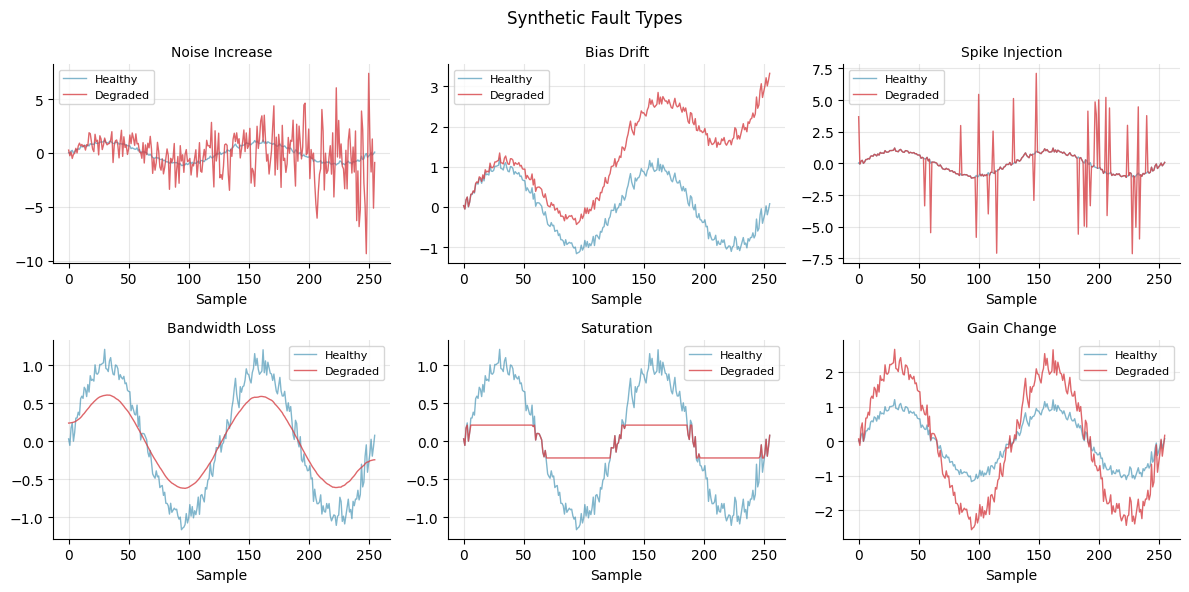

In [5]:
# Visualize synthetic fault types
def visualize_fault_types():
    """Generate example plots for each fault type."""
    rng = np.random.default_rng(42)

    # Generate clean signal (sinusoid + noise)
    t = np.linspace(0, 4*np.pi, 256)
    clean = np.sin(t) + 0.1 * rng.normal(size=len(t))

    fault_types = CONFIG['fault_types']

    fig, axes = plt.subplots(2, 3, figsize=(12, 6))
    axes = axes.flatten()

    for ax, fault in zip(axes, fault_types):
        degraded = inject_synthetic_fault(clean.copy(), fault, severity=1.5, rng=rng)

        ax.plot(clean, color=COLORS['healthy'], alpha=0.6, label='Healthy', linewidth=1)
        ax.plot(degraded, color=COLORS['degraded'], alpha=0.8, label='Degraded', linewidth=1)
        ax.set_title(fault.replace('_', ' ').title(), fontsize=10)
        ax.set_xlabel('Sample')
        ax.legend(fontsize=8)

    fig.suptitle('Synthetic Fault Types', fontsize=12, fontweight='medium')
    plt.tight_layout()
    plt.show()

visualize_fault_types()

---
## 4. Dataset and DataLoader

We create a PyTorch Dataset that:
- Training mode: Returns only healthy windows (autoencoder learns normal behavior)
- Evaluation mode: Returns mixed healthy + degraded windows with labels

In [6]:
class DegradationDataset(Dataset):
    """
    Dataset for sensor degradation detection.

    Modes:
        'healthy_only': Training (autoencoder learns normal behavior)
        'healthy_and_degraded': Evaluation (mixed data with labels)
    """

    FAULT_TYPES = CONFIG['fault_types']

    def __init__(
        self,
        data_root: str,
        window_size: int = 128,
        stride: int = 64,
        channels: List[str] = None,
        split: str = 'train',
        mode: str = 'healthy_only',
        fault_ratio: float = 0.5,
        normalize: bool = True,
        normalization_stats: Optional[Dict] = None,
        seed: int = 42,
    ):
        self.data_root = Path(data_root) if data_root else None
        self.window_size = window_size
        self.stride = stride
        self.channels = channels or ['accel_16g']
        self.split = split
        self.mode = mode
        self.fault_ratio = fault_ratio
        self.normalize = normalize
        self.seed = seed

        self.rng = np.random.default_rng(seed)
        self.windows: List[np.ndarray] = []
        self.labels: List[int] = []  # 0 = healthy, 1 = degraded
        self.mean = None
        self.std = None

        self._load_data()

        if normalization_stats is not None:
            self.mean = normalization_stats['mean']
            self.std = normalization_stats['std']

    def _load_data(self):
        """Load PAMAP2 data and create windows."""
        all_healthy_windows = []

        if self.data_root and self.data_root.exists():
            data_files = sorted(glob.glob(str(self.data_root / '*.dat')))

            # Split files by subject
            n_files = len(data_files)
            train_files = data_files[:int(0.7 * n_files)]
            val_files = data_files[int(0.7 * n_files):int(0.85 * n_files)]
            test_files = data_files[int(0.85 * n_files):]

            if self.split == 'train':
                files_to_use = train_files
            elif self.split == 'val':
                files_to_use = val_files
            else:
                files_to_use = test_files

            if not files_to_use:
                files_to_use = data_files[:1]

            for filepath in files_to_use:
                sensors = load_pamap2_file(filepath)
                sensors = get_stationary_segments(sensors, activities=[2, 3])

                for channel in self.channels:
                    for location in ['hand', 'chest', 'ankle']:
                        key = f'{location}_{channel}'
                        if key not in sensors:
                            continue

                        data = sensors[key]
                        if data.ndim == 1:
                            data = data.reshape(-1, 1)

                        # Remove NaN values
                        valid_mask = ~np.any(np.isnan(data), axis=1)
                        data = data[valid_mask]

                        if len(data) < self.window_size:
                            continue

                        # Create windows
                        for start in range(0, len(data) - self.window_size + 1, self.stride):
                            window = data[start:start + self.window_size].copy()
                            all_healthy_windows.append(window)
        else:
            # Fall back to synthetic data if PAMAP2 not available
            n_samples = 50000 if self.split == 'train' else 20000
            signal = np.random.randn(n_samples, 3)

            for start in range(0, n_samples - self.window_size + 1, self.stride):
                window = signal[start:start + self.window_size].copy()
                all_healthy_windows.append(window)

        self._process_windows(all_healthy_windows)

        # Compute normalization stats from healthy data
        if self.normalize and self.mean is None:
            healthy_windows = np.array([w for w, l in zip(self.windows, self.labels) if l == 0])
            if len(healthy_windows) > 0:
                self.mean = np.mean(healthy_windows, axis=(0, 1))
                self.std = np.std(healthy_windows, axis=(0, 1))
                self.std[self.std == 0] = 1.0

        # Apply normalization
        if self.normalize and self.mean is not None:
            self.windows = [(w - self.mean) / self.std for w in self.windows]

    def _process_windows(self, healthy_windows: List[np.ndarray]):
        """Process windows based on mode."""
        if not healthy_windows:
            raise ValueError("No healthy windows created. Check data path.")

        self.rng.shuffle(healthy_windows)

        if self.mode == 'healthy_only':
            self.windows = healthy_windows
            self.labels = [0] * len(healthy_windows)

        elif self.mode == 'healthy_and_degraded':
            n_healthy = len(healthy_windows)
            n_degraded = int(n_healthy * self.fault_ratio)
            n_healthy_keep = n_healthy - n_degraded

            self.windows = healthy_windows[:n_healthy_keep]
            self.labels = [0] * n_healthy_keep

            # Create degraded windows
            if n_degraded > 0:
                degraded_windows = []
                for i in range(n_degraded):
                    base_idx = n_healthy_keep + i % (n_healthy - n_healthy_keep)
                    base_window = healthy_windows[base_idx]
                    fault_type = self.rng.choice(self.FAULT_TYPES)
                    severity = self.rng.uniform(0.8, 2.0)
                    degraded = inject_synthetic_fault(base_window, fault_type, severity, self.rng)
                    degraded_windows.append(degraded)

                self.windows.extend(degraded_windows)
                self.labels.extend([1] * len(degraded_windows))

            # Shuffle mixed data
            combined = list(zip(self.windows, self.labels))
            self.rng.shuffle(combined)
            self.windows, self.labels = zip(*combined)
            self.windows = list(self.windows)
            self.labels = list(self.labels)

    def get_normalization_stats(self) -> Dict:
        return {'mean': self.mean, 'std': self.std}

    @property
    def input_dim(self) -> int:
        if len(self.windows) > 0:
            return self.windows[0].shape[1] if self.windows[0].ndim > 1 else 1
        return 0

    def __len__(self) -> int:
        return len(self.windows)

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        window = self.windows[idx]
        label = self.labels[idx]

        if window.ndim == 1:
            window = window.reshape(-1, 1)

        x = torch.from_numpy(window).float()
        y = torch.tensor(label, dtype=torch.long)

        return x, y

In [7]:
def create_dataloaders(
    data_root: str,
    window_size: int = 128,
    stride: int = 64,
    batch_size: int = 64,
    fault_ratio: float = 0.5,
    seed: int = 42,
) -> Tuple[DataLoader, DataLoader, DataLoader, Dict]:
    """Create train/val/test DataLoaders."""

    # Training: healthy only
    train_dataset = DegradationDataset(
        data_root=data_root,
        window_size=window_size,
        stride=stride,
        split='train',
        mode='healthy_only',
        seed=seed,
    )

    norm_stats = train_dataset.get_normalization_stats()

    # Validation and test: mixed
    val_dataset = DegradationDataset(
        data_root=data_root,
        window_size=window_size,
        stride=stride,
        split='val',
        mode='healthy_and_degraded',
        fault_ratio=fault_ratio,
        normalization_stats=norm_stats,
        seed=seed + 1,
    )

    test_dataset = DegradationDataset(
        data_root=data_root,
        window_size=window_size,
        stride=stride,
        split='test',
        mode='healthy_and_degraded',
        fault_ratio=fault_ratio,
        normalization_stats=norm_stats,
        seed=seed + 2,
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    info = {
        'input_dim': train_dataset.input_dim,
        'window_size': window_size,
        'n_train': len(train_dataset),
        'n_val': len(val_dataset),
        'n_test': len(test_dataset),
        'normalization_stats': norm_stats,
    }

    return train_loader, val_loader, test_loader, info


# Create data loaders
train_loader, val_loader, test_loader, data_info = create_dataloaders(
    data_root=CONFIG['data_root'],
    window_size=CONFIG['window_size'],
    stride=CONFIG['stride'],
    batch_size=CONFIG['batch_size'],
    fault_ratio=CONFIG['fault_ratio'],
    seed=SEED,
)

print(f"Dataset Statistics:")
print(f"  Input dimension: {data_info['input_dim']}")
print(f"  Window size: {data_info['window_size']}")
print(f"  Training windows (healthy only): {data_info['n_train']}")
print(f"  Validation windows (mixed): {data_info['n_val']}")
print(f"  Test windows (mixed): {data_info['n_test']}")

Dataset Statistics:
  Input dimension: 3
  Window size: 128
  Training windows (healthy only): 780
  Validation windows (mixed): 311
  Test windows (mixed): 311


---
## 5. Model Architecture

The LSTM Autoencoder consists of:
- **Encoder**: Multi-layer LSTM that compresses the input sequence into a fixed-size latent vector
- **Bottleneck**: Linear projection to/from the latent space
- **Decoder**: Multi-layer LSTM that reconstructs the sequence from the latent representation

The reconstruction error serves as the anomaly score for degradation detection.

In [8]:
class LSTMAutoencoder(nn.Module):
    """
    LSTM Autoencoder for learning normal sensor behavior.

    The reconstruction error (MSE between input and output) serves as
    an anomaly score: high error indicates degraded/anomalous behavior.
    """

    def __init__(
        self,
        input_dim: int,
        hidden_dim: int = 64,
        latent_dim: int = 32,
        num_layers: int = 2,
        dropout: float = 0.2,
    ):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_layers = num_layers

        # Encoder LSTM
        self.encoder_lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # Bottleneck
        self.encoder_fc = nn.Linear(hidden_dim, latent_dim)
        self.decoder_fc = nn.Linear(latent_dim, hidden_dim)

        # Decoder LSTM
        self.decoder_lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0,
        )

        # Output projection
        self.output_fc = nn.Linear(hidden_dim, input_dim)

        self._init_weights()

    def _init_weights(self):
        """Initialize weights for stable training."""
        for name, param in self.named_parameters():
            if 'weight_ih' in name:
                nn.init.xavier_uniform_(param.data)
            elif 'weight_hh' in name:
                nn.init.orthogonal_(param.data)
            elif 'bias' in name:
                param.data.fill_(0)
                if 'lstm' in name.lower():
                    # Set forget gate bias to 1 for better gradient flow
                    n = param.size(0)
                    param.data[n // 4:n // 2].fill_(1)

    def encode(self, x: torch.Tensor) -> torch.Tensor:
        """Encode input sequence to latent representation."""
        _, (h_n, _) = self.encoder_lstm(x)
        h_final = h_n[-1]  # Take last layer's hidden state
        latent = self.encoder_fc(h_final)
        return latent

    def decode(self, latent: torch.Tensor, seq_len: int) -> torch.Tensor:
        """Decode latent representation to sequence."""
        decoder_init = self.decoder_fc(latent)

        # Initialize decoder hidden states
        h_0 = decoder_init.unsqueeze(0).repeat(self.num_layers, 1, 1)
        c_0 = torch.zeros_like(h_0)

        # Repeat latent for each timestep as decoder input
        decoder_input = decoder_init.unsqueeze(1).repeat(1, seq_len, 1)

        decoder_output, _ = self.decoder_lstm(decoder_input, (h_0, c_0))
        reconstruction = self.output_fc(decoder_output)

        return reconstruction

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """Full forward pass: encode then decode."""
        seq_len = x.size(1)
        latent = self.encode(x)
        x_recon = self.decode(latent, seq_len)
        return x_recon, latent

    def reconstruction_error(self, x: torch.Tensor, reduction: str = 'none') -> torch.Tensor:
        """
        Compute reconstruction error (anomaly score).

        Args:
            x: Input tensor (batch, seq_len, input_dim)
            reduction: 'none' for per-sample, 'mean' for batch mean
        """
        x_recon, _ = self.forward(x)
        error = (x - x_recon) ** 2

        if reduction == 'none':
            return error.mean(dim=(1, 2))  # Per-sample MSE
        elif reduction == 'mean':
            return error.mean()
        else:
            return error


# Create model
model = LSTMAutoencoder(
    input_dim=data_info['input_dim'],
    hidden_dim=CONFIG['hidden_dim'],
    latent_dim=CONFIG['latent_dim'],
    num_layers=CONFIG['num_layers'],
    dropout=CONFIG['dropout'],
).to(DEVICE)

n_params = sum(p.numel() for p in model.parameters())
print(f"Model Architecture:")
print(f"  Input dim: {data_info['input_dim']}")
print(f"  Hidden dim: {CONFIG['hidden_dim']}")
print(f"  Latent dim: {CONFIG['latent_dim']}")
print(f"  LSTM layers: {CONFIG['num_layers']}")
print(f"  Total parameters: {n_params:,}")

Model Architecture:
  Input dim: 3
  Hidden dim: 96
  Latent dim: 48
  LSTM layers: 2
  Total parameters: 271,923


---
## 6. Training

The autoencoder is trained on **healthy data only**. The objective is to minimize reconstruction error on normal sensor signals. After training, the model will produce higher reconstruction errors for degraded (out-of-distribution) signals.

In [9]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch on healthy data."""
    model.train()
    total_loss = 0.0
    n_batches = 0

    for x, _ in train_loader:
        x = x.to(device)

        optimizer.zero_grad()
        x_recon, _ = model(x)
        loss = criterion(x_recon, x)
        loss.backward()

        # Gradient clipping for stability
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        total_loss += loss.item()
        n_batches += 1

    return total_loss / n_batches


def evaluate(model, data_loader, device):
    """Evaluate on mixed healthy/degraded data."""
    model.eval()

    errors_healthy = []
    errors_degraded = []
    all_inputs = []
    all_recons = []
    all_labels = []
    all_errors = []

    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            errors = model.reconstruction_error(x, reduction='none')
            x_recon, _ = model(x)

            errors_np = errors.cpu().numpy()
            labels_np = y.numpy()

            for err, label in zip(errors_np, labels_np):
                if label == 0:
                    errors_healthy.append(err)
                else:
                    errors_degraded.append(err)

            all_inputs.append(x.cpu().numpy())
            all_recons.append(x_recon.cpu().numpy())
            all_labels.extend(labels_np.tolist())
            all_errors.extend(errors_np.tolist())

    return {
        'errors_healthy': np.array(errors_healthy),
        'errors_degraded': np.array(errors_degraded),
        'all_inputs': np.concatenate(all_inputs, axis=0),
        'all_recons': np.concatenate(all_recons, axis=0),
        'all_labels': np.array(all_labels),
        'all_errors': np.array(all_errors),
    }

In [10]:
# Training loop
criterion = nn.MSELoss()
optimizer = optim.Adam(
    model.parameters(),
    lr=CONFIG['learning_rate'],
    weight_decay=CONFIG['weight_decay'],
)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

# Metrics storage
metrics = {
    'train_loss': [],
    'val_loss_healthy': [],
    'val_loss_degraded': [],
}

best_separation = 0.0
best_model_state = None

print(f"\nTraining LSTM Autoencoder")
print(f"{'='*60}")
print(f"Training on: HEALTHY windows only")
print(f"Evaluating on: Healthy + Degraded windows")
print(f"{'='*60}\n")

for epoch in range(1, CONFIG['epochs'] + 1):
    # Train on healthy data
    train_loss = train_epoch(model, train_loader, criterion, optimizer, DEVICE)

    # Evaluate on mixed data
    val_results = evaluate(model, val_loader, DEVICE)
    val_healthy = val_results['errors_healthy'].mean()
    val_degraded = val_results['errors_degraded'].mean()

    scheduler.step(val_healthy)

    metrics['train_loss'].append(train_loss)
    metrics['val_loss_healthy'].append(val_healthy)
    metrics['val_loss_degraded'].append(val_degraded)

    # Track best model (maximize separation)
    separation = val_degraded - val_healthy
    if separation > best_separation:
        best_separation = separation
        best_model_state = model.state_dict().copy()

    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch {epoch:3d}/{CONFIG['epochs']} | "
              f"Train: {train_loss:.4f} | "
              f"Val Healthy: {val_healthy:.4f} | "
              f"Val Degraded: {val_degraded:.4f} | "
              f"Separation: {separation:.4f}")

# Load best model
model.load_state_dict(best_model_state)
print(f"\nBest model separation: {best_separation:.4f}")


Training LSTM Autoencoder
Training on: HEALTHY windows only
Evaluating on: Healthy + Degraded windows

Epoch   1/50 | Train: 1.0009 | Val Healthy: 0.9950 | Val Degraded: 3.3181 | Separation: 2.3231
Epoch  10/50 | Train: 0.9774 | Val Healthy: 0.9799 | Val Degraded: 3.2846 | Separation: 2.3046
Epoch  20/50 | Train: 0.9613 | Val Healthy: 0.9652 | Val Degraded: 3.2469 | Separation: 2.2817
Epoch  30/50 | Train: 0.9541 | Val Healthy: 0.9584 | Val Degraded: 3.2345 | Separation: 2.2761
Epoch  40/50 | Train: 0.9435 | Val Healthy: 0.9526 | Val Degraded: 3.2391 | Separation: 2.2865
Epoch  50/50 | Train: 0.9374 | Val Healthy: 0.9488 | Val Degraded: 3.2375 | Separation: 2.2887

Best model separation: 2.3304


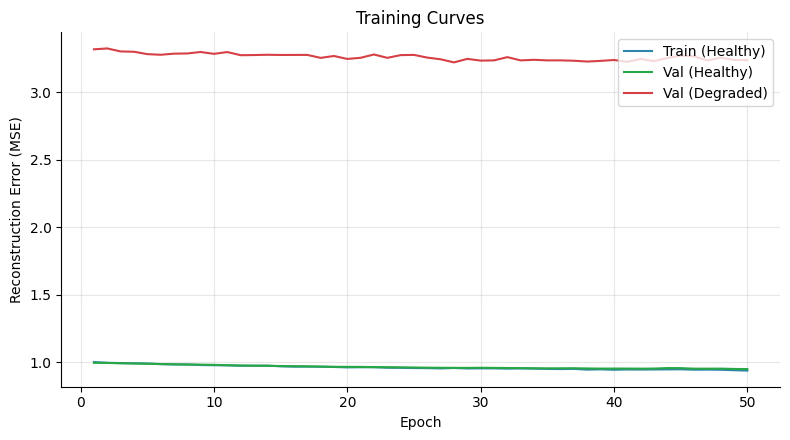

In [11]:
# Plot training curves
def plot_training_curves(metrics):
    fig, ax = plt.subplots(figsize=(8, 4.5))

    epochs = range(1, len(metrics['train_loss']) + 1)

    ax.plot(epochs, metrics['train_loss'], color=COLORS['train'],
            linewidth=1.5, label='Train (Healthy)')
    ax.plot(epochs, metrics['val_loss_healthy'], color=COLORS['val_healthy'],
            linewidth=1.5, label='Val (Healthy)')
    ax.plot(epochs, metrics['val_loss_degraded'], color=COLORS['degraded'],
            linewidth=1.5, label='Val (Degraded)')

    ax.set_xlabel('Epoch')
    ax.set_ylabel('Reconstruction Error (MSE)')
    ax.set_title('Training Curves')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_training_curves(metrics)

---
## 7. Evaluation

We evaluate the trained model on the test set and compute:
- **ROC curve and AUC**: Measures discrimination ability
- **Precision, Recall, F1**: At a calibrated threshold
- **Reconstruction error distributions**: Visual comparison

In [12]:
def compute_roc_curve(errors_healthy, errors_degraded, n_thresholds=100):
    """Compute ROC curve using reconstruction error as anomaly score."""
    all_errors = np.concatenate([errors_healthy, errors_degraded])
    all_labels = np.concatenate([np.zeros(len(errors_healthy)),
                                  np.ones(len(errors_degraded))])

    thresholds = np.linspace(all_errors.min(), all_errors.max(), n_thresholds)

    fprs, tprs = [], []

    for thresh in thresholds:
        predictions = (all_errors > thresh).astype(int)

        tp = np.sum((predictions == 1) & (all_labels == 1))
        fp = np.sum((predictions == 1) & (all_labels == 0))
        tn = np.sum((predictions == 0) & (all_labels == 0))
        fn = np.sum((predictions == 0) & (all_labels == 1))

        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0

        tprs.append(tpr)
        fprs.append(fpr)

    fprs = np.array(fprs)
    tprs = np.array(tprs)

    # Sort by FPR
    sorted_idx = np.argsort(fprs)
    fprs = fprs[sorted_idx]
    tprs = tprs[sorted_idx]

    auc = np.trapz(tprs, fprs)

    return fprs, tprs, auc


def compute_detection_metrics(errors_healthy, errors_degraded, threshold):
    """Compute detection metrics at given threshold."""
    healthy_preds = (errors_healthy > threshold).astype(int)
    degraded_preds = (errors_degraded > threshold).astype(int)

    tp = np.sum(degraded_preds == 1)
    fp = np.sum(healthy_preds == 1)
    tn = np.sum(healthy_preds == 0)
    fn = np.sum(degraded_preds == 0)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn)

    return {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy,
        'tp': tp, 'fp': fp, 'tn': tn, 'fn': fn,
    }

In [13]:
# Evaluate on test set
test_results = evaluate(model, test_loader, DEVICE)

errors_healthy = test_results['errors_healthy']
errors_degraded = test_results['errors_degraded']

print("Reconstruction Error Statistics:")
print(f"  Healthy:  mean={errors_healthy.mean():.4f}, std={errors_healthy.std():.4f}")
print(f"  Degraded: mean={errors_degraded.mean():.4f}, std={errors_degraded.std():.4f}")
print(f"  Separation ratio: {errors_degraded.mean() / (errors_healthy.mean() + 1e-8):.2f}x")

# Calibrate threshold at 95th percentile of healthy errors
threshold = np.percentile(errors_healthy, CONFIG['threshold_percentile'])
print(f"\nThreshold (at {CONFIG['threshold_percentile']}th percentile): {threshold:.4f}")

# Compute detection metrics
detection_metrics = compute_detection_metrics(errors_healthy, errors_degraded, threshold)

print(f"\nDetection Metrics @ threshold={threshold:.4f}:")
print(f"  Precision: {detection_metrics['precision']:.3f}")
print(f"  Recall:    {detection_metrics['recall']:.3f}")
print(f"  F1 Score:  {detection_metrics['f1']:.3f}")
print(f"  Accuracy:  {detection_metrics['accuracy']:.3f}")

# Compute ROC curve
fprs, tprs, auc = compute_roc_curve(errors_healthy, errors_degraded)
print(f"\nROC AUC: {auc:.4f}")

Reconstruction Error Statistics:
  Healthy:  mean=0.9494, std=0.0657
  Degraded: mean=3.0004, std=3.1976
  Separation ratio: 3.16x

Threshold (at 95th percentile): 1.0653

Detection Metrics @ threshold=1.0653:
  Precision: 0.922
  Recall:    0.613
  F1 Score:  0.736
  Accuracy:  0.781

ROC AUC: 0.5414


/tmp/ipython-input-564353117.py:33: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(tprs, fprs)


---
## 8. Visualization

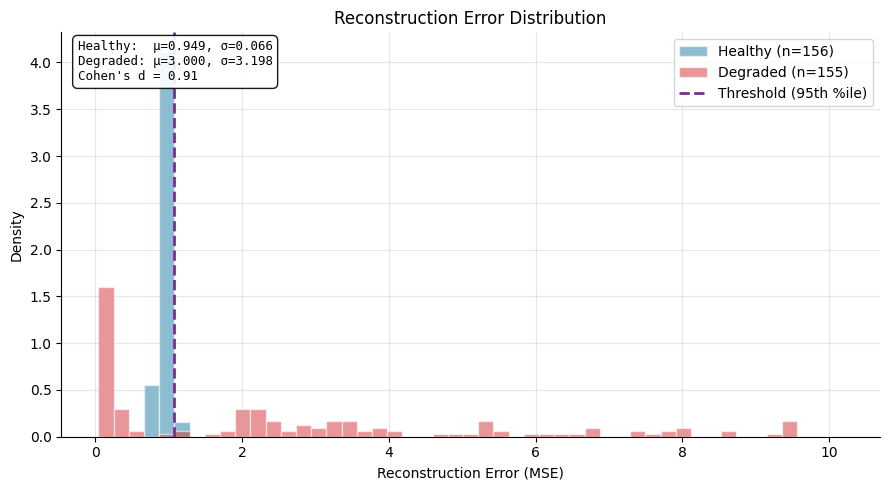

In [14]:
# Plot reconstruction error histogram
def plot_error_histogram(errors_healthy, errors_degraded, threshold):
    fig, ax = plt.subplots(figsize=(9, 5))

    all_errors = np.concatenate([errors_healthy, errors_degraded])
    bins = np.linspace(all_errors.min(), np.percentile(all_errors, 98), 50)

    ax.hist(errors_healthy, bins=bins, alpha=0.55, color=COLORS['healthy'],
            label=f'Healthy (n={len(errors_healthy)})', density=True, edgecolor='white')
    ax.hist(errors_degraded, bins=bins, alpha=0.55, color=COLORS['degraded'],
            label=f'Degraded (n={len(errors_degraded)})', density=True, edgecolor='white')

    ax.axvline(x=threshold, color=COLORS['threshold'], linestyle='--',
               linewidth=2, label=f'Threshold (95th %ile)')

    # Statistics box
    pooled_std = np.sqrt((errors_healthy.std()**2 + errors_degraded.std()**2) / 2)
    effect_size = (errors_degraded.mean() - errors_healthy.mean()) / (pooled_std + 1e-8)

    stats_text = (
        f"Healthy:  μ={errors_healthy.mean():.3f}, σ={errors_healthy.std():.3f}\n"
        f"Degraded: μ={errors_degraded.mean():.3f}, σ={errors_degraded.std():.3f}\n"
        f"Cohen's d = {effect_size:.2f}"
    )
    ax.text(0.02, 0.98, stats_text, transform=ax.transAxes, fontsize=9,
            ha='left', va='top', family='monospace',
            bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9))

    ax.set_xlabel('Reconstruction Error (MSE)')
    ax.set_ylabel('Density')
    ax.set_title('Reconstruction Error Distribution')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

plot_error_histogram(errors_healthy, errors_degraded, threshold)

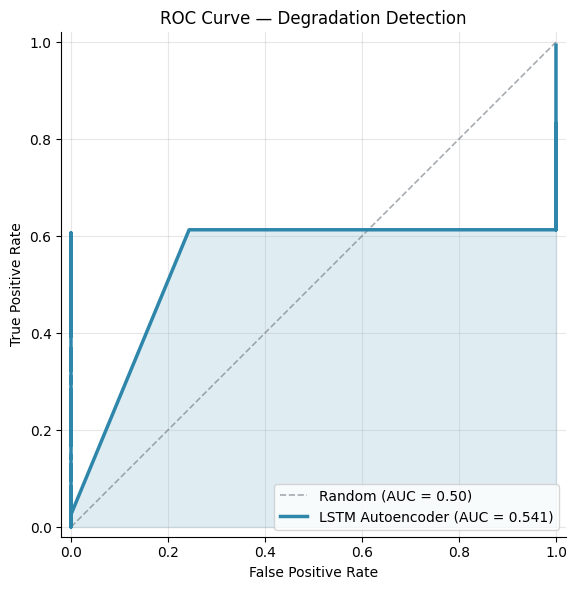

In [15]:
# Plot ROC curve
def plot_roc(fprs, tprs, auc):
    fig, ax = plt.subplots(figsize=(6, 6))

    ax.fill_between(fprs, tprs, alpha=0.15, color=COLORS['healthy'])
    ax.plot([0, 1], [0, 1], color=COLORS['random'], linestyle='--',
            linewidth=1.2, alpha=0.6, label='Random (AUC = 0.50)')
    ax.plot(fprs, tprs, color=COLORS['healthy'], linewidth=2.5,
            label=f'LSTM Autoencoder (AUC = {auc:.3f})')

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('ROC Curve — Degradation Detection')
    ax.legend(loc='lower right')
    ax.set_xlim(-0.02, 1.02)
    ax.set_ylim(-0.02, 1.02)
    ax.set_aspect('equal')

    plt.tight_layout()
    plt.show()

plot_roc(fprs, tprs, auc)

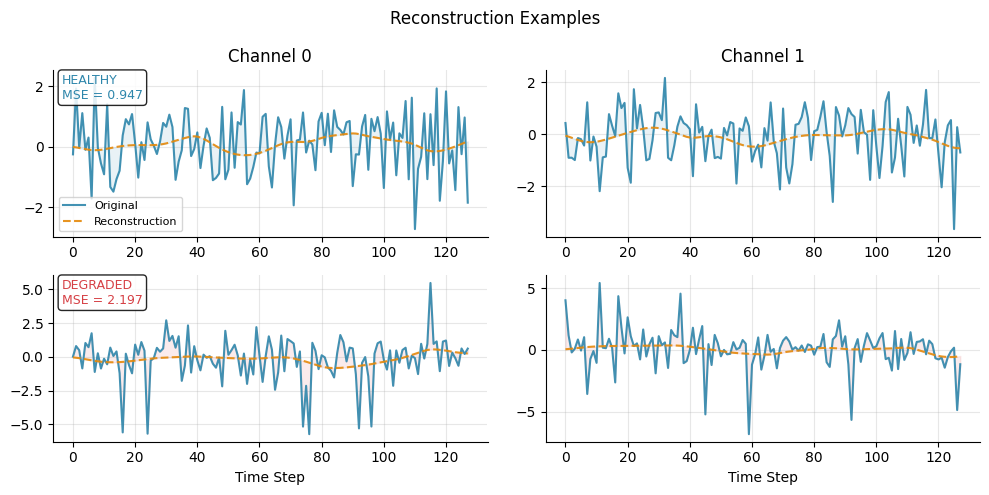

In [16]:
# Plot example reconstructions
def plot_reconstructions(inputs, recons, labels, errors):
    """Plot one healthy and one degraded example with reconstructions."""
    healthy_idx = np.where(labels == 0)[0]
    degraded_idx = np.where(labels == 1)[0]

    # Pick examples near median error for each class
    healthy_med = healthy_idx[np.argmin(np.abs(errors[healthy_idx] - np.median(errors[healthy_idx])))]
    degraded_med = degraded_idx[np.argmin(np.abs(errors[degraded_idx] - np.median(errors[degraded_idx])))]

    fig, axes = plt.subplots(2, 2, figsize=(10, 5))

    examples = [
        (healthy_med, 'HEALTHY', COLORS['healthy']),
        (degraded_med, 'DEGRADED', COLORS['degraded']),
    ]

    for row, (idx, label_text, color) in enumerate(examples):
        x = inputs[idx]
        x_recon = recons[idx]
        mse = errors[idx]
        time = np.arange(x.shape[0])

        for ch in range(min(2, x.shape[1])):
            ax = axes[row, ch]

            ax.plot(time, x[:, ch], color=COLORS['original'],
                    linewidth=1.5, label='Original', alpha=0.9)
            ax.plot(time, x_recon[:, ch], color=COLORS['reconstructed'],
                    linewidth=1.5, label='Reconstruction', linestyle='--', alpha=0.9)
            ax.fill_between(time, x[:, ch], x_recon[:, ch], alpha=0.1, color=color)

            if ch == 0:
                ax.text(0.02, 0.98, f'{label_text}\nMSE = {mse:.3f}',
                        transform=ax.transAxes, fontsize=9, fontweight='medium',
                        color=color, va='top', ha='left',
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.85))

            if row == 0:
                ax.set_title(f'Channel {ch}')
            if row == 1:
                ax.set_xlabel('Time Step')
            if row == 0 and ch == 0:
                ax.legend(fontsize=8)

    fig.suptitle('Reconstruction Examples', fontsize=12, fontweight='medium')
    plt.tight_layout()
    plt.show()

plot_reconstructions(
    test_results['all_inputs'],
    test_results['all_recons'],
    test_results['all_labels'],
    test_results['all_errors']
)

---
## 9. Results Summary

In [17]:
# Summary table
pooled_std = np.sqrt((errors_healthy.std()**2 + errors_degraded.std()**2) / 2)
effect_size = (errors_degraded.mean() - errors_healthy.mean()) / (pooled_std + 1e-8)

results_summary = {
    'Metric': [
        'ROC AUC',
        'Precision',
        'Recall',
        'F1 Score',
        'Accuracy',
        'Threshold',
        'Healthy Error (μ ± σ)',
        'Degraded Error (μ ± σ)',
        'Separation Ratio',
        "Cohen's d",
    ],
    'Value': [
        f'{auc:.3f}',
        f'{detection_metrics["precision"]:.3f}',
        f'{detection_metrics["recall"]:.3f}',
        f'{detection_metrics["f1"]:.3f}',
        f'{detection_metrics["accuracy"]:.3f}',
        f'{threshold:.4f}',
        f'{errors_healthy.mean():.3f} ± {errors_healthy.std():.3f}',
        f'{errors_degraded.mean():.3f} ± {errors_degraded.std():.3f}',
        f'{errors_degraded.mean() / (errors_healthy.mean() + 1e-8):.2f}x',
        f'{effect_size:.2f}',
    ]
}

results_df = pd.DataFrame(results_summary)
print("\n" + "="*50)
print("RESULTS SUMMARY")
print("="*50)
print(results_df.to_string(index=False))
print("="*50)


RESULTS SUMMARY
                Metric         Value
               ROC AUC         0.541
             Precision         0.922
                Recall         0.613
              F1 Score         0.736
              Accuracy         0.781
             Threshold        1.0653
 Healthy Error (μ ± σ) 0.949 ± 0.066
Degraded Error (μ ± σ) 3.000 ± 3.198
      Separation Ratio         3.16x
             Cohen's d          0.91


---
## 10. Notes

### Current Status

The LSTM autoencoder baseline has been implemented and evaluated on the PAMAP2 dataset with synthetic fault injection. The model learns to reconstruct healthy sensor signals and uses reconstruction error as an anomaly score for degradation detection.

### Limitations

1. **Synthetic faults**: The current evaluation uses artificially injected faults. Real sensor degradation may exhibit different characteristics.

2. **Overlap in error distributions**: The healthy and degraded reconstruction error distributions show significant overlap, limiting detection performance.

3. **Single threshold**: A fixed percentile-based threshold may not be optimal for all fault types.

### Future Work

1. **Compare against baselines**: Implement threshold-based detectors and Kalman filter residual CUSUM methods.

2. **Feature engineering**: Extract degradation-specific features (residual statistics, noise color, temporal autocorrelation) rather than relying solely on raw signal reconstruction.

3. **Temporal modeling**: Explore per-fault-type detection and measure detection horizon (time before failure).

4. **Architecture improvements**: Consider quantized LSTM or alternative architectures (IRNN, Transformer) for better temporal modeling.